# Transfer Learning Hubble Image Similarity Processing

In [1]:
import pickle
import os
import shutil

from tldist.fingerprint.processing import FingerprintCalculatorResnet
from tldist.fingerprint.processing import calculate as fingerprint_calculate
from tldist.similarity.similarity import calculate as similarity_calculate
from tldist.data import Data
from tldist.cutout.generators import FullImageCutoutGenerator
from tldist.database import get_database

db = get_database('blitzdb', 'basic_notebook_100.db')

## Load the pre-massaged data

The pickle file contains a list of dictionaries. Each dictionary represents an image and contains info about the file location, RA/DEC and meta data (observation information).

For example:
```
{'location': 'http://18.218.192.161:4123/ACSimages/j6jt03020_drz_small.jpg',
 'meta': {'calib_level': 3,
  'dataRights': 'PUBLIC',
  'dataURL': 'mast:HST/product/j6jt03020_drz.fits',
  'dataproduct_type': 'image',
  'em_max': 7.08e-07,
  'em_min': 9.59e-07,
  'filters': 'F814W',
  'instrument_name': 'ACS/WFC',
  'intentType': 'science',
  'jpegURL': 'mast:HST/product/j6jt03020_drz.jpg',
  'mtFlag': False,
  'objID': '2000000046',
  'obs_collection': 'HST',
  'obs_id': 'j6jt03020',
  'obs_title': 'Massive Black Holes in Early Type Galaxies',
  'obsid': '2003859773',
  'project': 'HST',
  'proposal_id': '9293',
  'proposal_pi': 'Ford, Holland',
  'proposal_type': 'GTO/ACS',
  's_dec': -50.44308333333,
  's_ra': 113.484125,
  's_region': 'POLYGON 113.44645052 -50.42181811 113.4384584 -50.44956291 113.52376071 -50.46441676 113.53283592 -50.43611022 113.44645052 -50.42181811 113.44645052 -50.42181811',
  'srcDen': masked,
  't_exptime': 857.0448000216857,
  't_max': 52845.0091944,
  't_min': 52845.0191139,
  't_obs_release': 53211.01324,
  'target_classification': 'field',
  'target_name': 'ESO208-G21',
  'wavelength_region': 'Optical'},
 'radec': (113.484125, -50.44308333333)}
 ```

In [2]:
# Load the data
processing_dict = pickle.load(open('../data/hubble_acs.pck', 'rb'))

## Save the Image Data

Each data element will be saved to a Data object in order to confirm input is correct and then save to a database for later retrival. An example image is: 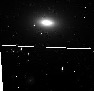

In [3]:
data = []
for fileinfo in processing_dict[:100]:
    im = Data(location=fileinfo['location'], radec=fileinfo['radec'], meta=fileinfo['meta'])
    data.append(im)
    db.save('data', im)

## Create the Cutouts

Cutouts of the images will be made. The cutouts in this case represent a 224x224 cutout of the data and these cutouts will be stored in the database too. The cutouts could have other types of image processing applied to the underlying data.

In [4]:
full_cutout = FullImageCutoutGenerator(output_size=(224, 224))

In [6]:
cutouts = []
for datum in data:
    cutout = full_cutout.create_cutouts(datum)
    db.save('cutout', cutout)
    cutouts.append(cutout)

INFO     2018-05-11 10:13:24,226 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,291 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,344 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,379 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,415 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,468 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,520 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,573 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,624 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,676 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,727 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:24,779 cutout gen

INFO     2018-05-11 10:13:28,538 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:28,575 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:28,610 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:28,647 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:28,683 cutout generator get_data   Data going to be returned


## Compute the Fingerprints

Compute the fingerprints from each of the cutouts based on, in this case, the Resnet50 pre-trained network.  The fingerprints are stored in the database too.  The Fingerprint calculator will calculate based on the [Resnet50](https://keras.io/applications/#resnet50), [VGG16](https://keras.io/applications/#vgg16), [VGG19](https://keras.io/applications/#vgg19), [InceptionV3](https://keras.io/applications/#inceptionv3) or [InceptionResnetV2](https://keras.io/applications/#inceptionresnetv2) pre-trained networks.  The fingerprints are computed using [Keras](https://keras.io) and [Google's Tensorflow backend](https://www.tensorflow.org).

The fingerprint will look something like:
```
[['n04286575', 'spotlight', 0.39021581411361694],
 ['n09229709', 'bubble', 0.1927020102739334],
 ['n02788148', 'bannister', 0.06545353680849075],
 ['n03388043', 'fountain', 0.04016595706343651],
 ['n03028079', 'church', 0.020774058997631073],
 ['n03976657', 'pole', 0.019223248586058617],
 ['n03196217', 'digital_clock', 0.018269173800945282],
 ['n04366367', 'suspension_bridge', 0.014173725619912148],
 ['n04589890', 'window_screen', 0.01129070296883583],
 ['n02793495', 'barn', 0.008158819749951363],
 ['n03857828', 'oscilloscope', 0.007918311282992363],
 ['n03874599', 'padlock', 0.007855708710849285],
 ['n04507155', 'umbrella', 0.00783586222678423],
 ['n03000134', 'chainlink_fence', 0.006827631965279579],
 ```

In [7]:
# This will take a minute as it is loading the pre-trained network
fresnet = FingerprintCalculatorResnet()
fc_save = fresnet.save()

/Users/crjones/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/crjones/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
fingerprints = fingerprint_calculate(cutouts, fc_save)
[db.save('fingerprint', x) for x in fingerprints]

INFO     2018-05-11 10:13:40,976 fingerprint processing calculate  
INFO     2018-05-11 10:13:40,977 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:41,477 fingerprint processing calculate  Calculate prediction took 0.5000619888305664s
INFO     2018-05-11 10:13:41,479 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:41,761 fingerprint processing calculate  Calculate prediction took 0.2814600467681885s
INFO     2018-05-11 10:13:41,762 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:42,061 fingerprint processing calculate  Calculate prediction took 0.29843616485595703s
INFO     2018-05-11 10:13:42,062 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:42,372 fingerprint processing calculate  Calculate prediction took 0.30940842628479004s
INFO     2018-05-11 10:13:42,373 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:42,940 fingerprin

INFO     2018-05-11 10:13:56,527 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:56,855 fingerprint processing calculate  Calculate prediction took 0.3273470401763916s
INFO     2018-05-11 10:13:56,856 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:57,188 fingerprint processing calculate  Calculate prediction took 0.3309612274169922s
INFO     2018-05-11 10:13:57,189 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:57,525 fingerprint processing calculate  Calculate prediction took 0.33558011054992676s
INFO     2018-05-11 10:13:57,526 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:57,840 fingerprint processing calculate  Calculate prediction took 0.3133811950683594s
INFO     2018-05-11 10:13:57,841 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:13:58,170 fingerprint processing calculate  Calculate prediction took 0.3276491165161133s

INFO     2018-05-11 10:14:10,082 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:14:10,413 fingerprint processing calculate  Calculate prediction took 0.3298637866973877s
INFO     2018-05-11 10:14:10,414 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:14:10,744 fingerprint processing calculate  Calculate prediction took 0.3295021057128906s
INFO     2018-05-11 10:14:10,746 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:14:11,076 fingerprint processing calculate  Calculate prediction took 0.3295109272003174s
INFO     2018-05-11 10:14:11,077 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:14:11,412 fingerprint processing calculate  Calculate prediction took 0.33434510231018066s
INFO     2018-05-11 10:14:11,413 cutout generator get_data   Data going to be returned
INFO     2018-05-11 10:14:11,719 fingerprint processing calculate  Calculate prediction took 0.30475711822509766

['74e597ef-2f1d-4123-9531-6595328c2628',
 'e43357fe-475b-40ce-a551-c4d5c1a1b1a7',
 '425e1cec-ea9c-4990-b008-4eb7a5a4f7a8',
 '456b85cc-96a0-4b7c-8d0a-dc2de2fcdead',
 'fe94cf85-159f-4cdf-90c0-affece6c97d5',
 '315de16a-d80b-4271-ac4d-28b8be90b6f8',
 '5811c22f-f491-42a4-a7f6-a24d5f262706',
 '789ccd7b-c1bf-4288-b9ef-b7bfc46c82c1',
 '38e94e45-7c65-4dc7-8c67-5d4dec9054e0',
 'c4e6532a-ada1-4e75-b359-4f533188162f',
 '52d427a5-3411-4d89-9e46-3d6c4d4b5989',
 'd42a8a0d-2e00-4c5e-8463-109ea6eb8ffa',
 '88eb069c-adf4-4066-a247-fb84400959bf',
 '3124c728-0ec9-455e-8501-5f8ae60332ee',
 'cc3e9b0d-bf3a-49fe-9836-d5fb5ddf3389',
 '5a575bd2-4b46-4990-a212-64505398fedc',
 'ca01ca18-088a-4b9f-97f0-497249c45755',
 '5a240a15-d6ec-4816-8a7e-c14c73d19f9f',
 '1a20c26a-f3a3-4547-9e3f-d693a899ee4d',
 '6977ce1b-4c4e-4dab-9683-ac7a3ed2f844',
 '61ae9ce0-c7ce-4a68-8320-2a3d88ae3884',
 'c7d0bd05-ddd5-465c-bdaa-f60b7bd36e71',
 '71a039a9-6ea4-4706-b053-1de026a9a8f5',
 '46fbaa86-67be-4995-9dbc-fd8105d5f4a6',
 '5f832d02-8c6b-

## Compute the Similarity

Once the fingerprints are calculated, next the similarity is calculated. In this case the [tSNE algorithm](https://lvdmaaten.github.io/tsne/) is used which is a data reduction algorithm and enables determining similar cutouts given one cutout.  The tSNE similarity is represented by a 2D plot where each element is a fingerprint (and therefore represents a cutout of an image). For example:
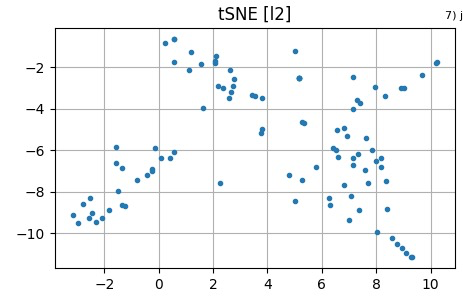

In [9]:
similarity_tsne = similarity_calculate(fingerprints, 'tsne')
db.save('similarity', similarity_tsne)

INFO     2018-05-11 10:14:32,998 similarity calculate  Start threaded real_calculate 100 fingerprints and simcalc tsne
INFO     2018-05-11 10:14:32,999 similarity __init__   Created tsne
INFO     2018-05-11 10:14:33,000 similarity calculate  Going to calculate tSNE from 100 fingerprints
INFO     2018-05-11 10:14:33,543 similarity calculate  Unique labels ['spotlight', 'bubble', 'bannister', 'fountain', 'church', 'pole', 'digital_clock', 'suspension_bridge', 'window_screen', 'barn', 'oscilloscope', 'padlock', 'umbrella', 'chainlink_fence', 'web_site', 'solar_dish', 'theater_curtain', 'spider_web', 'parallel_bars', 'picket_fence', 'monitor', 'balloon', 'laptop', 'grand_piano', 'lighter', 'matchstick', 'abaya', 'sliding_door', 'dishwasher', 'horizontal_bar', 'traffic_light', 'digital_watch', 'obelisk', 'television', 'bathtub', 'stage', 'crate', 'analog_clock', 'park_bench', 'greenhouse', 'notebook', 'tub', 'tripod', 'ski', 'screen', 'planetarium', 'ashcan', 'swing', 'hourglass', 'window_s

INFO     2018-05-11 10:14:34,182 similarity calculate  Calculating the tSNE...
INFO     2018-05-11 10:14:35,437 similarity calculate  Done calculation
INFO     2018-05-11 10:14:35,437 similarity save       Returning the dictionary of information


'1d3605b9-7173-4677-9cf8-86bc6db70503'